In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [12]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter % 5 == 0:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [89]:
# Load full Data
df_full = pd.read_csv('data/processed/SimpleNNData.csv', index_col=0)
y = df_full.time_to_reservation
df_full.drop(columns=['time_to_reservation'], inplace=True)
weather_var = list(df_full.columns[-22:-1])

## Simple network

In [28]:
df = df_full.drop(columns=['dist_to_station', 'degree']+weather_var, inplace = False)
df

,park_fuel,weekend,hour_index,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,lz_102121,lz_102122,...,lz_185122,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203
0,43,0,6.805269,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,86,0,6.805269,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,0,6.805269,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,30,0,6.805269,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,32,0,6.805269,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326733,94,0,6.457874,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326734,57,0,6.457874,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326735,48,0,6.457874,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326736,23,0,6.457874,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [30]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(268,128),
            nn.ReLU(nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,64),
            nn.ReLU(nn.BatchNorm1d(64)),
            nn.Dropout(0.5),
            nn.Linear(64,32),
            nn.ReLU(nn.BatchNorm1d(32)),
            nn.Dropout(0.5),
            nn.Linear(32,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=268, out_features=128, bias=True)
    (1): ReLU(
      inplace=True
      (inplace): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU(
      inplace=True
      (inplace): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU(
      inplace=True
      (inplace): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
) 45249


In [31]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 23.061567 , Valid Loss 19.660896 ,Train R2 0.148917, Valid R2 0.143051
Epoch 11: Train Loss 19.313877 , Valid Loss 19.094945 ,Train R2 0.183274, Valid R2 0.167719
EarlyStopping counter: 5 out of 10
Epoch 21: Train Loss 19.062170 , Valid Loss 19.047925 ,Train R2 0.189273, Valid R2 0.169769
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 24: Train Loss 19.000605 , Valid Loss 19.034056 , Train R2 0.190616, Valid R2 0.170373


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

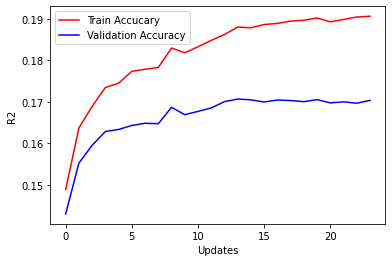

In [32]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

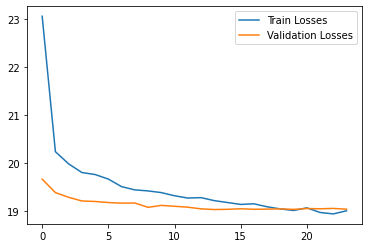

0.17223356389952715


In [33]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

## With embedding

In [ ]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.embedding = nn.Embedding 

        self.seq = nn.Sequential(
            nn.Linear(263,128),
            nn.ReLU(nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,64),
            nn.ReLU(nn.BatchNorm1d(64)),
            nn.Dropout(0.5),
            nn.Linear(64,32),
            nn.ReLU(nn.BatchNorm1d(32)),
            nn.Dropout(0.5),
            nn.Linear(32,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

In [344]:
X_train[2,7:].int().argmax()

tensor(146)

In [345]:
emb(X_train[:,7:].int())[2,:,:]

tensor([[-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
 

In [319]:
input = torch.LongTensor([[1,2,4,5],[4,3,2,9]])
emb(input)

tensor([[[-1.1585,  2.0188,  2.1123],
         [ 0.7063, -1.2334, -0.2562],
         [-1.9014,  0.3058,  0.3674],
         [ 0.5342, -1.6928, -0.4252]],

        [[-1.9014,  0.3058,  0.3674],
         [ 1.0778,  0.6448,  0.6322],
         [ 0.7063, -1.2334, -0.2562],
         [-1.2688, -0.6102,  0.4146]]], grad_fn=<EmbeddingBackward0>)

In [291]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*lz).*$')-train_data.filter(regex = '^(?!.*lz).*$').mean())/train_data.filter(regex = '^(?!.*lz).*$').std(ddof = 1), train_data.filter(regex = 'lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*lz).*$')-val_data.filter(regex = '^(?!.*lz).*$').mean())/val_data.filter(regex = '^(?!.*lz).*$').std(ddof = 1), val_data.filter(regex = 'lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*lz).*$')-test_data.filter(regex = '^(?!.*lz).*$').mean())/test_data.filter(regex = '^(?!.*lz).*$').std(ddof = 1), test_data.filter(regex = 'lz')], axis = 1)

In [292]:
X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

## With degree

In [90]:
df = df_full.drop(columns=['dist_to_station']+weather_var, inplace = False)
df

,park_fuel,degree,weekend,hour_index,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,lz_102121,...,lz_185122,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203
0,43,12.529378,0,6.805269,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,86,14.027280,0,6.805269,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,17.751882,0,6.805269,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,30,1.806991,0,6.805269,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,32,13.214864,0,6.805269,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326733,94,20.556195,0,6.457874,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326734,57,14.221806,0,6.457874,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326735,48,16.451925,0,6.457874,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326736,23,15.140361,0,6.457874,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [92]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(269,128),
            nn.ReLU(nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,128),
            nn.ReLU(nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,64),
            nn.ReLU(nn.BatchNorm1d(64)),
            nn.Dropout(0.5),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=269, out_features=128, bias=True)
    (1): ReLU(
      inplace=True
      (inplace): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU(
      inplace=True
      (inplace): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(
      inplace=True
      (inplace): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 60033


In [93]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 21.696434 , Valid Loss 18.739473 ,Train R2 0.169704, Valid R2 0.167899
Epoch 11: Train Loss 18.474907 , Valid Loss 17.978186 ,Train R2 0.221324, Valid R2 0.201703
EarlyStopping counter: 5 out of 10
Epoch 21: Train Loss 18.137436 , Valid Loss 17.984580 ,Train R2 0.227371, Valid R2 0.201419
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 23: Train Loss 18.080052 , Valid Loss 17.973760 , Train R2 0.228504, Valid R2 0.201900


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

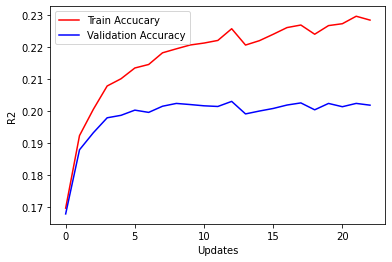

In [94]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

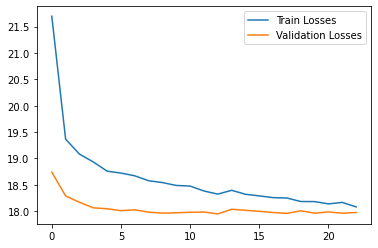

0.20512599141658117


In [95]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

## With Dist to Station

In [96]:
df = df_full.drop(columns=weather_var+['degree'], inplace = False)
df

,park_fuel,weekend,hour_index,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,lz_102121,lz_102122,...,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203,dist_to_station
0,43,0,6.805269,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,386.856080
1,86,0,6.805269,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1096.295483
2,5,0,6.805269,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,812.660741
3,30,0,6.805269,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,897.592806
4,32,0,6.805269,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,599.103807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326733,94,0,6.457874,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,275.431500
326734,57,0,6.457874,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,546.398658
326735,48,0,6.457874,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,615.556913
326736,23,0,6.457874,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,495.570805


In [97]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [98]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(269,128),
            nn.ReLU(nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,128),
            nn.ReLU(nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,64),
            nn.ReLU(nn.BatchNorm1d(64)),
            nn.Dropout(0.5),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=269, out_features=128, bias=True)
    (1): ReLU(
      inplace=True
      (inplace): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU(
      inplace=True
      (inplace): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(
      inplace=True
      (inplace): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 60033


In [99]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 22.100417 , Valid Loss 19.117730 ,Train R2 0.152779, Valid R2 0.150707
Epoch 11: Train Loss 19.179825 , Valid Loss 18.716551 ,Train R2 0.184959, Valid R2 0.168529
Epoch 21: Train Loss 18.897304 , Valid Loss 18.627533 ,Train R2 0.195020, Valid R2 0.172484
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 5 out of 10
Epoch 31: Train Loss 18.750270 , Valid Loss 18.601212 ,Train R2 0.200465, Valid R2 0.173653
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 35: Train Loss 18.710625 , Valid Loss 18.620379 , Train R2 0.201236, Valid R2 0.172802


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

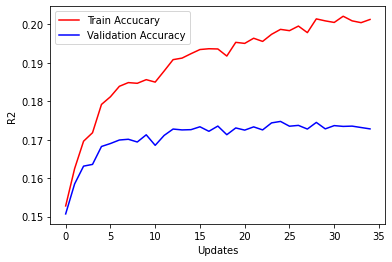

In [100]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

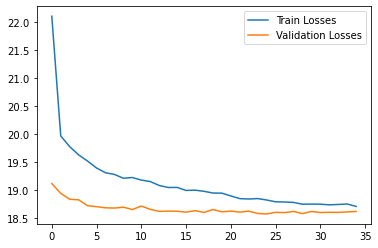

0.1648511316088116


In [101]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

## With both

In [102]:
df = df_full.drop(columns=weather_var, inplace = False)
df

,park_fuel,degree,weekend,hour_index,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,lz_102121,...,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203,dist_to_station
0,43,12.529378,0,6.805269,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,386.856080
1,86,14.027280,0,6.805269,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1096.295483
2,5,17.751882,0,6.805269,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,812.660741
3,30,1.806991,0,6.805269,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,897.592806
4,32,13.214864,0,6.805269,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,599.103807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326733,94,20.556195,0,6.457874,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,275.431500
326734,57,14.221806,0,6.457874,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,546.398658
326735,48,16.451925,0,6.457874,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,615.556913
326736,23,15.140361,0,6.457874,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,495.570805


In [103]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [107]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(270,128),
            nn.ReLU(nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,128),
            nn.ReLU(nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,64),
            nn.ReLU(nn.BatchNorm1d(64)),
            nn.Dropout(0.5),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=270, out_features=128, bias=True)
    (1): ReLU(
      inplace=True
      (inplace): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU(
      inplace=True
      (inplace): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(
      inplace=True
      (inplace): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 60161


In [108]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 21.677831 , Valid Loss 18.819406 ,Train R2 0.175722, Valid R2 0.170263
Epoch 11: Train Loss 18.363554 , Valid Loss 18.099335 ,Train R2 0.221133, Valid R2 0.202010
EarlyStopping counter: 5 out of 10
Epoch 21: Train Loss 18.008841 , Valid Loss 18.000725 ,Train R2 0.231640, Valid R2 0.206358
EarlyStopping counter: 5 out of 10
Epoch 31: Train Loss 17.843040 , Valid Loss 18.004192 ,Train R2 0.237552, Valid R2 0.206205
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 36: Train Loss 17.809567 , Valid Loss 17.984696 , Train R2 0.239170, Valid R2 0.207065


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

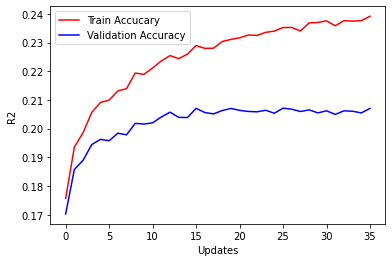

In [109]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

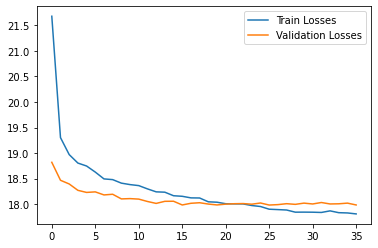

0.2071601225600027


In [110]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

## With weather

In [131]:
df = df_full.drop(df.filter(regex='Avg').columns,axis=1)
df

,park_fuel,degree,weekend,hour_index,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,lz_102121,...,lz_185154,lz_185203,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,mean_cloud_cover,dist_to_station
0,43,12.529378,0,6.805269,0,0,1,0,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,386.856080
1,86,14.027280,0,6.805269,0,0,1,0,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,1096.295483
2,5,17.751882,0,6.805269,1,0,0,0,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,812.660741
3,30,1.806991,0,6.805269,0,0,1,0,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,897.592806
4,32,13.214864,0,6.805269,0,1,0,0,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,599.103807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326733,94,20.556195,0,6.457874,0,0,1,0,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,275.431500
326734,57,14.221806,0,6.457874,1,0,0,0,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,546.398658
326735,48,16.451925,0,6.457874,1,0,0,0,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,615.556913
326736,23,15.140361,0,6.457874,0,0,1,0,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,495.570805


In [117]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [120]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(277,128),
            nn.ReLU(nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,128),
            nn.ReLU(nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,64),
            nn.ReLU(nn.BatchNorm1d(64)),
            nn.Dropout(0.5),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=277, out_features=128, bias=True)
    (1): ReLU(
      inplace=True
      (inplace): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU(
      inplace=True
      (inplace): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(
      inplace=True
      (inplace): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 61057


In [121]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.005) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 18.916297 , Valid Loss 18.782848 ,Train R2 0.163144, Valid R2 0.160088
Epoch 11: Train Loss 17.542901 , Valid Loss 17.806885 ,Train R2 0.223903, Valid R2 0.203730
EarlyStopping counter: 5 out of 10
Epoch 21: Train Loss 17.289368 , Valid Loss 17.702622 ,Train R2 0.235119, Valid R2 0.208392
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 31: Train Loss 17.181264 , Valid Loss 17.733973 , Train R2 0.239902, Valid R2 0.206990


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

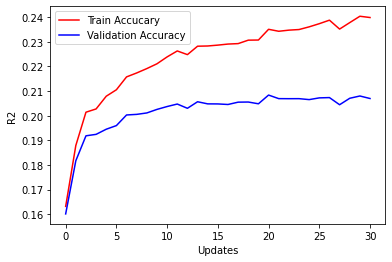

In [122]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        #cur_loss_train.append(batch_loss.item())
    #train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

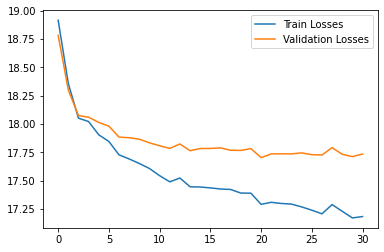

0.20576538524225352


In [123]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

## Average weather (cheat)

In [140]:
df = df_full.drop(weather_var[:7]+weather_var[-7:],axis=1)
df

,park_fuel,degree,weekend,hour_index,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,lz_102121,...,lz_185154,lz_185203,Avg_mean_temp,Avg_mean_wind_speed,Avg_acc_precip,Avg_bright_sunshine,Avg_mean_pressure,Avg_mean_relative_hum,Avg_mean_cloud_cover,dist_to_station
0,43,12.529378,0,6.805269,0,0,1,0,0,0,...,0,0,15.044444,1.688889,0.0,0.033333,1012.855556,73.877778,79.444444,386.856080
1,86,14.027280,0,6.805269,0,0,1,0,0,0,...,0,0,14.775000,1.487500,0.0,0.000000,1013.050000,74.612500,85.125000,1096.295483
2,5,17.751882,0,6.805269,1,0,0,0,0,0,...,0,0,14.775000,1.487500,0.0,0.000000,1013.050000,74.612500,85.125000,812.660741
3,30,1.806991,0,6.805269,0,0,1,0,0,0,...,0,0,14.433333,1.333333,0.0,0.000000,1013.450000,74.866667,81.166667,897.592806
4,32,13.214864,0,6.805269,0,1,0,0,0,0,...,0,0,14.557143,1.357143,0.0,0.000000,1013.242857,75.128571,83.571429,599.103807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326733,94,20.556195,0,6.457874,0,0,1,0,0,0,...,0,0,4.214286,2.071429,0.0,0.000000,1019.414286,96.385714,41.857143,275.431500
326734,57,14.221806,0,6.457874,1,0,0,0,0,0,...,0,0,4.444444,2.355556,0.0,0.000000,1019.311111,96.155556,38.222222,546.398658
326735,48,16.451925,0,6.457874,1,0,0,0,0,0,...,0,0,4.444444,2.355556,0.0,0.000000,1019.311111,96.155556,38.222222,615.556913
326736,23,15.140361,0,6.457874,0,0,1,0,0,0,...,0,0,4.066667,1.916667,0.0,0.000000,1019.466667,96.183333,33.833333,495.570805


In [141]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [142]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(277,128),
            nn.ReLU(nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,128),
            nn.ReLU(nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,64),
            nn.ReLU(nn.BatchNorm1d(64)),
            nn.Dropout(0.5),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=277, out_features=128, bias=True)
    (1): ReLU(
      inplace=True
      (inplace): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU(
      inplace=True
      (inplace): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(
      inplace=True
      (inplace): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 61057


In [143]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.005) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 18.412720 , Valid Loss 18.320707 ,Train R2 0.188139, Valid R2 0.181886
Epoch 11: Train Loss 12.400250 , Valid Loss 13.078337 ,Train R2 0.453243, Valid R2 0.415985
Epoch 21: Train Loss 11.689296 , Valid Loss 12.572951 ,Train R2 0.484591, Valid R2 0.438553
Epoch 31: Train Loss 11.384493 , Valid Loss 12.500010 ,Train R2 0.498030, Valid R2 0.441810
Epoch 41: Train Loss 11.112207 , Valid Loss 12.286581 ,Train R2 0.510036, Valid R2 0.451341
Epoch 51: Train Loss 10.841849 , Valid Loss 12.089327 ,Train R2 0.521957, Valid R2 0.460149
EarlyStopping counter: 5 out of 10
Epoch 61: Train Loss 10.895921 , Valid Loss 12.082351 ,Train R2 0.519573, Valid R2 0.460461
EarlyStopping counter: 5 out of 10
Epoch 71: Train Loss 10.609011 , Valid Loss 11.913629 ,Train R2 0.532223, Valid R2 0.467995
Epoch 81: Train Loss 10.644503 , Valid Loss 11.885249 ,Train R2 0.530658, Valid R2 0.469262
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 89: Train 

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

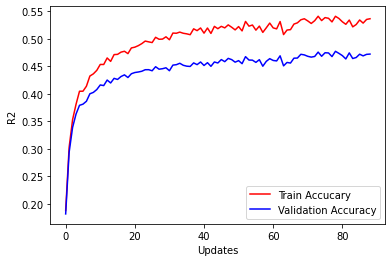

In [144]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        #cur_loss_train.append(batch_loss.item())
    #train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

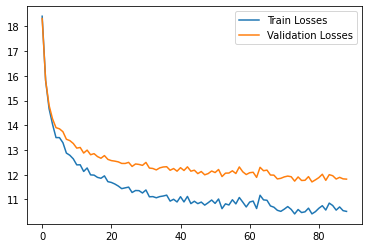

0.475958048667953


In [145]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

## Only average weather

In [147]:
df_w = df_full[weather_var[7:14]]
df_w

,Avg_mean_temp,Avg_mean_wind_speed,Avg_acc_precip,Avg_bright_sunshine,Avg_mean_pressure,Avg_mean_relative_hum,Avg_mean_cloud_cover
0,15.044444,1.688889,0.0,0.033333,1012.855556,73.877778,79.444444
1,14.775000,1.487500,0.0,0.000000,1013.050000,74.612500,85.125000
2,14.775000,1.487500,0.0,0.000000,1013.050000,74.612500,85.125000
3,14.433333,1.333333,0.0,0.000000,1013.450000,74.866667,81.166667
4,14.557143,1.357143,0.0,0.000000,1013.242857,75.128571,83.571429
...,...,...,...,...,...,...,...
326733,4.214286,2.071429,0.0,0.000000,1019.414286,96.385714,41.857143
326734,4.444444,2.355556,0.0,0.000000,1019.311111,96.155556,38.222222
326735,4.444444,2.355556,0.0,0.000000,1019.311111,96.155556,38.222222
326736,4.066667,1.916667,0.0,0.000000,1019.466667,96.183333,33.833333


In [148]:
train_val, test_data, y_train_val, y_test = train_test_split(df_w, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [149]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(7,128),
            nn.ReLU(nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,128),
            nn.ReLU(nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,64),
            nn.ReLU(nn.BatchNorm1d(64)),
            nn.Dropout(0.5),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): ReLU(
      inplace=True
      (inplace): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU(
      inplace=True
      (inplace): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(
      inplace=True
      (inplace): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 26497


In [150]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.005) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 20.638355 , Valid Loss 20.712778 ,Train R2 0.084066, Valid R2 0.081519
Epoch 11: Train Loss 14.298267 , Valid Loss 14.458125 ,Train R2 0.365441, Valid R2 0.358873
Epoch 21: Train Loss 13.615026 , Valid Loss 13.818452 ,Train R2 0.395763, Valid R2 0.387239
Epoch 31: Train Loss 13.044568 , Valid Loss 13.198117 ,Train R2 0.421080, Valid R2 0.414747
Epoch 41: Train Loss 12.940625 , Valid Loss 13.143591 ,Train R2 0.425693, Valid R2 0.417164
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 5 out of 10
Epoch 51: Train Loss 12.571235 , Valid Loss 12.764409 ,Train R2 0.442087, Valid R2 0.433979
EarlyStopping counter: 5 out of 10
Epoch 61: Train Loss 12.559329 , Valid Loss 12.761987 ,Train R2 0.442615, Valid R2 0.434086
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 68: Train Loss 12.598789 , Valid Loss 12.807229 , Train R2 0.440864, Valid R2 0.432080


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

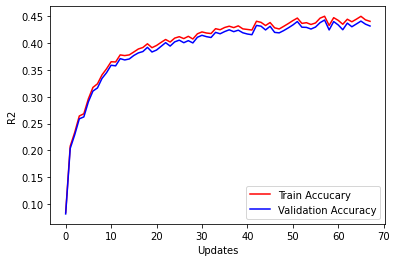

In [151]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        #cur_loss_train.append(batch_loss.item())
    #train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

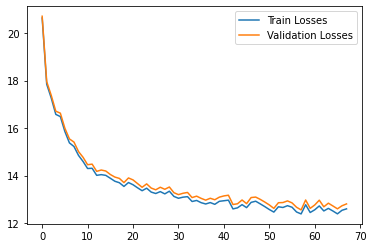

0.42548492922196113


In [152]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

## With weather (index)

In [153]:
df = df_full.drop(weather_var[:14],axis=1)
df

,park_fuel,degree,weekend,hour_index,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,lz_102121,...,lz_185154,lz_185203,Avg_Index_mean_temp,Avg_Index_mean_wind_speed,Avg_Index_acc_precip,Avg_Index_bright_sunshine,Avg_Index_mean_pressure,Avg_Index_mean_relative_hum,Avg_Index_mean_cloud_cover,dist_to_station
0,43,12.529378,0,6.805269,0,0,1,0,0,0,...,0,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,386.856080
1,86,14.027280,0,6.805269,0,0,1,0,0,0,...,0,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,1096.295483
2,5,17.751882,0,6.805269,1,0,0,0,0,0,...,0,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,812.660741
3,30,1.806991,0,6.805269,0,0,1,0,0,0,...,0,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,897.592806
4,32,13.214864,0,6.805269,0,1,0,0,0,0,...,0,0,14.775000,1.487500,0.0,0.0,1013.050000,74.612500,85.125000,599.103807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326733,94,20.556195,0,6.457874,0,0,1,0,0,0,...,0,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,275.431500
326734,57,14.221806,0,6.457874,1,0,0,0,0,0,...,0,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,546.398658
326735,48,16.451925,0,6.457874,1,0,0,0,0,0,...,0,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,615.556913
326736,23,15.140361,0,6.457874,0,0,1,0,0,0,...,0,0,4.214286,2.071429,0.0,0.0,1019.414286,96.385714,41.857143,495.570805


In [154]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [155]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(277,128),
            nn.ReLU(nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,128),
            nn.ReLU(nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,64),
            nn.ReLU(nn.BatchNorm1d(64)),
            nn.Dropout(0.5),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=277, out_features=128, bias=True)
    (1): ReLU(
      inplace=True
      (inplace): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU(
      inplace=True
      (inplace): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(
      inplace=True
      (inplace): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 61057


In [156]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.005) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 18.858048 , Valid Loss 18.582293 ,Train R2 0.170801, Valid R2 0.169825
Epoch 11: Train Loss 17.452189 , Valid Loss 17.583203 ,Train R2 0.232617, Valid R2 0.214460
Epoch 21: Train Loss 17.244259 , Valid Loss 17.530082 ,Train R2 0.241760, Valid R2 0.216833
EarlyStopping counter: 5 out of 10
Epoch 31: Train Loss 17.107327 , Valid Loss 17.494337 ,Train R2 0.247781, Valid R2 0.218430
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 33: Train Loss 17.127721 , Valid Loss 17.497358 , Train R2 0.246884, Valid R2 0.218295


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

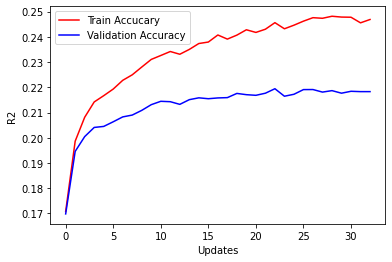

In [157]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        #cur_loss_train.append(batch_loss.item())
    #train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

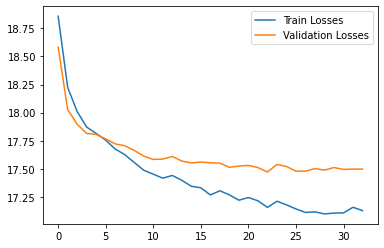

0.21332408260612223


In [158]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))